# Оценка районов/локаций Москвы с точки зрения их привлекательности для семей с детьми

**Задача:** необходимо сделать модель оценки районов\локаций Москвы с точки зрения их привлекательности для семей с детьми.

**Исходные данные:** shp-файлы скачаны с OpenStreetMap с помощью инструмента QuickOSM в QGIS (далее в скобках указаны ключ и значение данных в классификаторе OSM)
- границы районов Москвы (boundary = administrative),
- школы (amenity = school),
- детские сады, ясли, учреждения дошкольного образования (amenity = kindergarten),
- детские игровые площадки (leisure = playground),
- спортивные площадки (leisure = pitch),
- парки, открытые зелёные площадки для отдыха (leisure = park)
- многоквартирные жилые дома (building = apartments)

Все исходные данные представлены в векторном формате в системе координат EPSG:4326 - WGS84

**Нормативная база:** постановления Правительства Москвы об утверждении нормативов градостроительного проектирования, в которых определены нормативы территориальной доступности от многоквартирной жилой застройки до социально-значимых объектов (ниже в скобках указан номер документа):
1. школы - 300 метров (№ 2151-ПП),
2. детские сады, ясли, учереждения дошкольного образования - 300 метров (№ 2151-ПП),
3. детские игровые площадки - 300 метров (№ 2152-ПП),
4. спортивные площадки - 500 метров (№ 1557-ПП),
5. парки, открытые зелёные площадки для отдыха - 400 метров (№ 2152-ПП)

**Классификация в бинарной (дихотомической) шкале:** модель основана на пространственном анализе векторных данных, определит для каждого объекта жилого фонда Москвы, является ли он благоприятным для проживания с детьми (0 - неблаприятные условия, 1 - благоприятные)
- 1 (благоприятные условия) определяется выполнением всех условий по пяти показателям, перечисленным выше, т.е. объект жилого фонда попадает одновременно в 300-метровую зону от школы, 300-метровую зону от детского сада, 300-метровую зону от детской площадки и т.д.
- 0 (неблагоприятные) все условия по пяти показателям не выполняются.

**Классификация в ранговой шкале:** модель построит на основе пяти показателей непрерывную поверхность со значениями в диапазоне от 1 до 5, что означает 1 - самые благоприятные условия для семей с детьми, 5 - самые неблагоприятные, и определит значение для каждого объекта жилого фонда методом интерполяции. После округления полученных значений, мы получим классификацию объектов жилого фонда в ранговой шкале.

Обе модели могут быть масштабированы добавлением других социально-значимых объектов для семей с детьми.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def hist_percent(data, title):
    plt.figure(figsize=(6,4));
    sns.set(style='darkgrid')
    ax = sns.histplot(data, binwidth=1, stat="percent")      
    ax.bar_label(ax.containers[0])
    plt.title(title, fontsize=13, weight='bold');
    plt.ylabel('% объектов жилого фонда', fontsize=14);

In [3]:
def bar_class(data, name, xlabel, y):
    data.plot(kind='bar', stacked=True,figsize=(15, 6), x=name, y=y)
    plt.legend(title='Условия для проживания семей с детьми:', fontsize=14, loc=1, facecolor='white');
    plt.xlabel(xlabel, fontsize=14);
    plt.ylabel('количество объектов жилого фонда', fontsize=14);

## Классификация в бинарной (дихотомической) шкале

Модель составлена с помощью приложения ModelBuilder в ArcGIS Desktop. Она включает в себя следующие инструменты пространственного анализа:
- буфер,
- пересечение,
- пространственное соединение,
- изменение поля.

На выходе модели два векторных слоя (EPSG:4326):
1. **intersect** - граница зоны, благоприятной для проживания семей с детьми,
2. **result** - объекты многоквартирного жилого фонда в границах Москвы со следующими атрибутами:
 - `adm_name` - название района,
 - `okrug_name` - название округа,
 - `sub_ter` - территория города (Старая Москва/Новая Москва),
 - `addr_str_5` - название улицы,
 - `addr_hou_6` - номер дома,
 - `class` - классификация NULL (неблагоприятные), 1 (благоприятные)

Ниже представлена схема модели.

<img src='Image/model_binary.png' />

Границы зон, благоприятных для проживания семей с детьми.

<img src='Image/map_binary.jpg' />

Ниже приведен фрагмент карты с результатами исследования. Показана граница зоны, благоприятной для проживания семей с детьми, и синим подсвечены объекты жилого фонда, попадающие в границу этой зоны.

<img src='Image/zones_binary.jpg' />

### Исследовательский анализ результатов классификации

Далее проведем небольшой исследовательский анализ полученных табличных данных.
- посмотрим на распределение объектов жилого фонда по классам,
- посмотрим на графиках как распределен жилой фонд с благоприятными и неблагоприятными условиями для проживания семей с детьми по округам и районам Москвы,
- составим топ-10 районов Москвы с наибольшим количеством объектов жилого фонда, благоприятных для проживания семей с детьми.

In [4]:
# загрузка таблицы result с результатами исследования
df = pd.read_csv('result.txt', delimiter = ";")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33496 entries, 0 to 33495
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OBJECTID      33496 non-null  int64  
 1   Join_Count    33496 non-null  int64  
 2   TARGET_FID    33496 non-null  int64  
 3   Join_Count_1  33496 non-null  int64  
 4   TARGET_FID_1  33496 non-null  int64  
 5   full_id       33496 non-null  object 
 6   osm_id        33496 non-null  int64  
 7   osm_type      33496 non-null  object 
 8   building      33496 non-null  object 
 9   name          33496 non-null  object 
 10  start_date    33496 non-null  object 
 11  building14    33496 non-null  object 
 12  addr_str_5    33496 non-null  object 
 13  addr_hou_6    33496 non-null  object 
 14  class         17095 non-null  float64
 15  cell_zid      33496 non-null  int64  
 16  adm_name      33496 non-null  object 
 17  okrug_name    33496 non-null  object 
 18  sub_ter       33496 non-nu

Классификация объектов приведена в поле `class` со значениями NULL и 1.

Для более понятной интерпретации результатов изменим NULL на 'неблагоприятные' и 1 - на 'благоприятные'.

In [6]:
# Изменение типа поля на object
df['class'] = df['class'].astype('object')

In [7]:
df['class'] = df['class'].fillna('неблагоприятные')
df.loc[df['class'] == 1, 'class'] = 'благоприятные'

In [8]:
df.loc[:, ['adm_name', 'okrug_name', 'sub_ter', 'addr_str_5', 'addr_hou_6', 'class']].head(10)

,adm_name,okrug_name,sub_ter,addr_str_5,addr_hou_6,class
0,Раменки,Западный административный округ,Старая Москва,улица Довженко,6,неблагоприятные
1,Арбат,Центральный административный округ,Старая Москва,Романов переулок,5,неблагоприятные
2,Тверской,Центральный административный округ,Старая Москва,улица Большая Дмитровка,7/5 с3,неблагоприятные
3,Басманный,Центральный административный округ,Старая Москва,улица Машкова,13 с1,благоприятные
4,Красносельский,Центральный административный округ,Старая Москва,Сретенский бульвар,6/1 с2,неблагоприятные
5,Красносельский,Центральный административный округ,Старая Москва,улица Сретенка,26/1,благоприятные
6,Пресненский,Центральный административный округ,Старая Москва,Мерзляковский переулок,15,неблагоприятные
7,Западное Дегунино,Северный административный округ,Старая Москва,Дмитровское шоссе,81,неблагоприятные
8,Басманный,Центральный административный округ,Старая Москва,Новая Басманная улица,10 с1,благоприятные
9,Басманный,Центральный административный округ,Старая Москва,улица Покровка,29,благоприятные


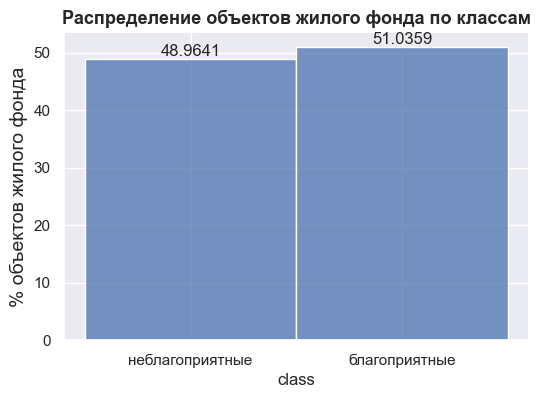

In [9]:
hist_percent(data=df['class'], title='Распределение объектов жилого фонда по классам')

Бинарная классификация разделила объекты жилого фонда Москвы примерно поровну: 51% - благоприятные условия, 49% - неблагоприятные.

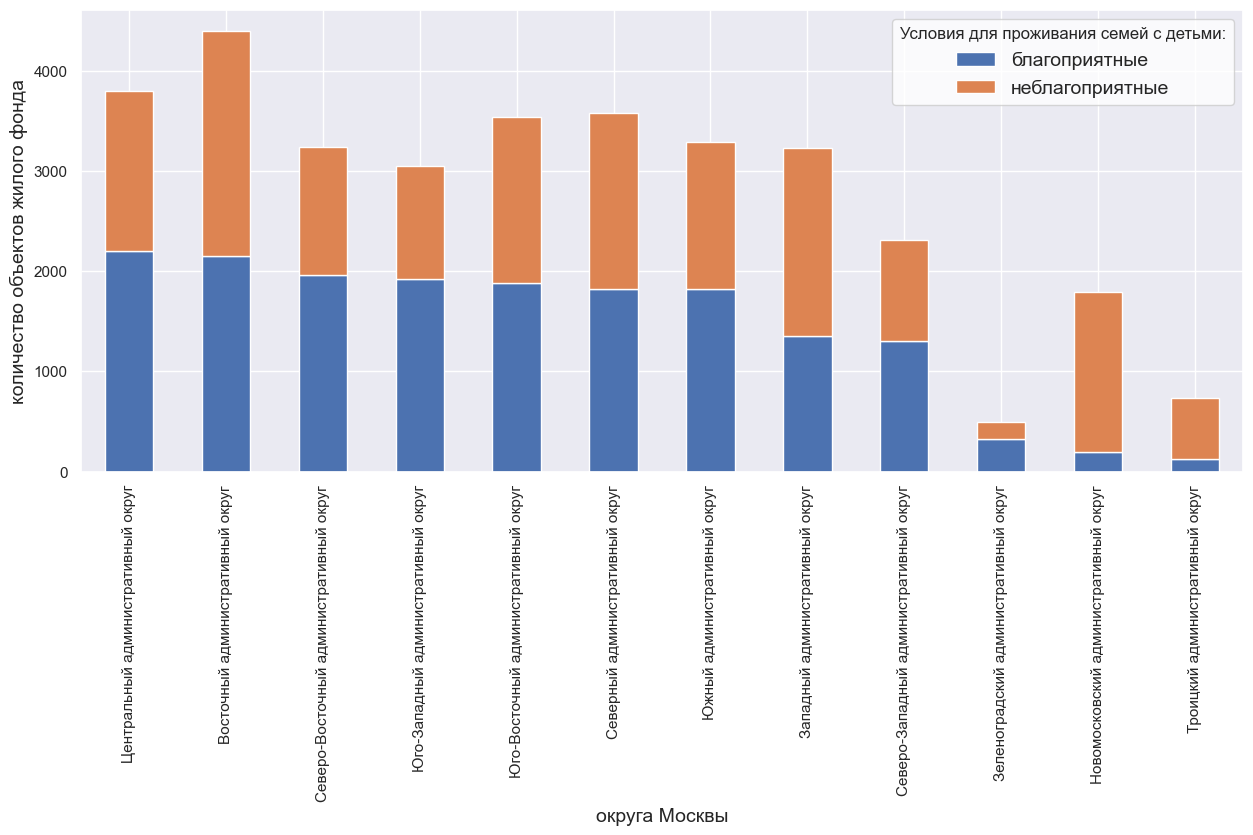

In [10]:
bar_class(data=df.pivot_table(index='okrug_name', values='full_id', columns='class', aggfunc='count').reset_index()\
    .sort_values('благоприятные', ascending=False), name="okrug_name", xlabel='округа Москвы',
           y=["благоприятные", "неблагоприятные"])

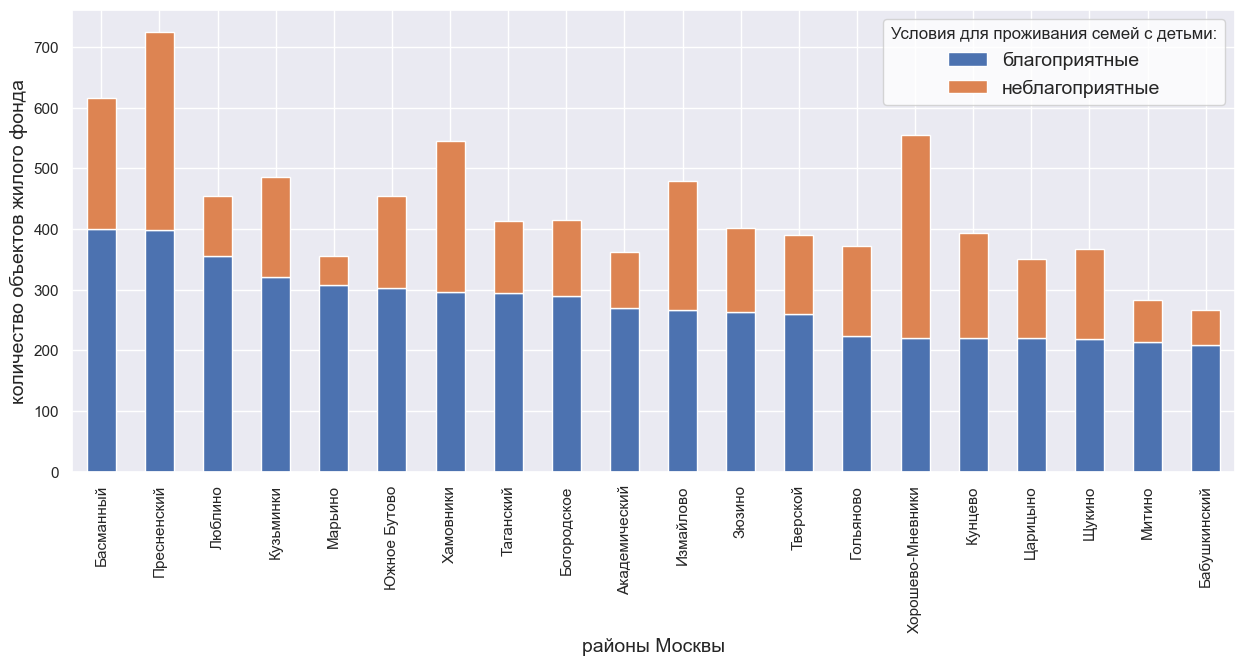

In [11]:
bar_class(data=df.pivot_table(index='adm_name', values='full_id', columns='class', aggfunc='count').reset_index()\
    .sort_values('благоприятные', ascending=False).head(20), name="adm_name", xlabel='районы Москвы',
          y=["благоприятные", "неблагоприятные"])

Из графиков следует, что в ЦАО и ВАО наибольшее количество объектов жилого фонда, благоприятного для проживания семей с детьми, среди районов лидируют - Басманный и Пресненский.

Далее составим таблицу топ-10 районов Москвы с наибольшим количеством объектов жилого фонда, благоприятного для проживания семей с детьми.

In [12]:
df.loc[df['class'] == 'благоприятные', :]\
    .pivot_table(index=['adm_name', 'okrug_name'], values='sub_ter', columns='class', aggfunc='count').reset_index()\
    .sort_values('благоприятные', ascending=False).head(10)

class,adm_name,okrug_name,благоприятные
6,Басманный,Центральный административный округ,400
88,Пресненский,Центральный административный округ,399
57,Люблино,Юго-Восточный административный округ,355
49,Кузьминки,Юго-Восточный административный округ,321
61,Марьино,Юго-Восточный административный округ,308
129,Южное Бутово,Юго-Западный административный округ,302
118,Хамовники,Центральный административный округ,297
109,Таганский,Центральный административный округ,295
12,Богородское,Восточный административный округ,290
0,Академический,Юго-Западный административный округ,270


In [13]:
df.loc[df['class'] == 'благоприятные', ['adm_name', 'okrug_name', 'sub_ter', 'addr_str_5', 'addr_hou_6', 'class']].head(10)

,adm_name,okrug_name,sub_ter,addr_str_5,addr_hou_6,class
3,Басманный,Центральный административный округ,Старая Москва,улица Машкова,13 с1,благоприятные
5,Красносельский,Центральный административный округ,Старая Москва,улица Сретенка,26/1,благоприятные
8,Басманный,Центральный административный округ,Старая Москва,Новая Басманная улица,10 с1,благоприятные
9,Басманный,Центральный административный округ,Старая Москва,улица Покровка,29,благоприятные
12,Басманный,Центральный административный округ,Старая Москва,Армянский переулок,7,благоприятные
13,Басманный,Центральный административный округ,Старая Москва,улица Солянка,1/2 с2,благоприятные
14,Басманный,Центральный административный округ,Старая Москва,улица Солянка,1/2 с1,благоприятные
22,Алексеевский,Северо-Восточный административный округ,Старая Москва,улица Бориса Галушкина,26,благоприятные
23,Алексеевский,Северо-Восточный административный округ,Старая Москва,проспект Мира,124 к17,благоприятные
24,Алексеевский,Северо-Восточный административный округ,Старая Москва,проспект Мира,124 к5,благоприятные


## Классификация в ранговой шкале

Модель составлена с помощью приложения ModelBuilder в ArcGIS Desktop. Она представляет собой Модель пригодности, которая используется для определения наилучшего местоположения объектов. Модель определит пригодность территории в ранговой шкале от 1 до 5. Она включает в себя следующие инструменты пространственного анализа:
- евклидово расстояние,
- переклассификация растра - значения переклассифицированы в шкалу от 1 до 5. ниже представлены значения в исходной шкале и после переклассификации. Для класса 1 взяты значения нормативов территориальной доступности.

**школы, детсткие сады, детские площадки:**

| Старое значение, м | Новое значение | 
| :-: | :-: |
| 0 - 300 | 1 | 
| 300 - 600 | 2 | 
| 600 - 1200 | 3 |
| 1200 - 2500 | 4 |
| более 2500 | 5 |

**парки:**

| Старое значение, м | Новое значение | 
| :-: | :-: |
| 0 - 400 | 1 | 
| 400 - 800 | 2 | 
| 800 - 1600 | 3 |
| 1600 - 3500 | 4 |
| более 3500 | 5 |

**спортивные площадки:**

| Старое значение, м | Новое значение | 
| :-: | :-: |
| 0 - 500 | 1 | 
| 500 - 1000 | 2 | 
| 1000 - 2000 | 3 |
| 2000 - 5000 | 4 |
| более 5000 | 5 |

- калькулятор растра - выполнено взвешенное наложение растров. Вес объектов влияет на классификацию, чем выше вес, тем большее влияние на итоговый класс. Были установлены следующие веса для объектов

| Объект | Вес, % | 
| :-: | :-: |
| школы | 25 | 
| детские сады | 25 | 
| детские площадки | 20 |
| парки | 20 |
| спортивные площадки | 10 |

- извлечение по маске,
- извлечение значения в точке,
- пространственное соединение,
- изменение поля.

Т.к. модель работает с растрами, то для корректной интерпретации результатов исходные данные должны быть представлены в системе координат, на которой можно проводить расчеты в метрах. Поэтому исходные данные предварительно были перепроецированы в Pulkovo_1942_GK_Zone_7 (EPSG:28407).

На выходе модели растровая поверхность и векторный слой (EPSG:28407):
1. **suitability_mos** - растровая поверхность со значениями в диапазоне 1-5, что означает 1 - наиболее благоприятные условия, 5 - неблагоприятные.
2. **result_rang** - объекты многоквартирного жилого фонда в границах Москвы со следующими атрибутами:
 - `adm_name` - название района,
 - `okrug_name` - название округа,
 - `sub_ter` - территория города (Старая Москва/Новая Москва),
 - `addr_str_5` - название улицы,
 - `addr_hou_6` - номер дома,
 - `rang` - значение в диапазоне 1-5.

Ниже представлена схема модели.

<img src='Image/model_rang.png' />

Фрагмент карты с результатами исследования. Показана растровая поверхность - каждый ранг классификации имеет свое цветовое оформление.

<img src='Image/map_rang.jpg' />

### Исследовательский анализ результатов классификации

Далее проведем небольшой исследовательский анализ полученных табличных данных.
- посмотрим на распределение объектов жилого фонда по классам,
- посмотрим на графиках как распределен жилой фонд с благоприятными и неблагоприятными условиями для проживания семей с детьми по округам и районам Москвы,
- составим топ-10 районов Москвы с наибольшим количеством объектов жилого фонда, благоприятных для проживания семей с детьми.

In [14]:
df2 = pd.read_csv('result_rang.txt', delimiter = ";", decimal=",")

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33492 entries, 0 to 33491
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    33492 non-null  int64  
 1   Join_Count  33492 non-null  int64  
 2   TARGET_FID  33492 non-null  int64  
 3   full_id     33492 non-null  object 
 4   osm_id      33492 non-null  int64  
 5   osm_type    33492 non-null  object 
 6   building    33492 non-null  object 
 7   name        33492 non-null  object 
 8   start_date  33492 non-null  object 
 9   building14  33492 non-null  object 
 10  addr_str_5  33492 non-null  object 
 11  addr_hou_6  33492 non-null  object 
 12  ORIG_FID    33492 non-null  int64  
 13  cell_zid    33492 non-null  int64  
 14  adm_name    33492 non-null  object 
 15  okrug_name  33492 non-null  object 
 16  sub_ter     33492 non-null  object 
 17  ter         33492 non-null  object 
 18  rang        33492 non-null  float64
dtypes: float64(1), int64(6), 

In [16]:
df2.head()

,OBJECTID,Join_Count,TARGET_FID,full_id,osm_id,osm_type,building,name,start_date,building14,addr_str_5,addr_hou_6,ORIG_FID,cell_zid,adm_name,okrug_name,sub_ter,ter,rang
0,1,1,1,r58174,58174,relation,apartments,,1976,10,улица Довженко,6,1,99790,Раменки,Западный административный округ,Старая Москва,Москва,1.40
1,2,1,2,r84844,84844,relation,apartments,,,5,Романов переулок,5,2,108666,Арбат,Центральный административный округ,Старая Москва,Москва,1.85
2,3,1,3,r85638,85638,relation,apartments,,,,улица Большая Дмитровка,7/5 с3,3,108671,Тверской,Центральный административный округ,Старая Москва,Москва,1.80
3,4,1,4,r87116,87116,relation,apartments,апарт-комплекс «Современник»,2019,4,улица Машкова,13 с1,4,109264,Басманный,Центральный административный округ,Старая Москва,Москва,1.00
4,5,1,5,r87118,87118,relation,apartments,,1899..1902,6,Сретенский бульвар,6/1 с2,5,110425,Красносельский,Центральный административный округ,Старая Москва,Москва,1.25


Округлим значения рангов до целых чисел и присвоим им название

In [17]:
df2['rang'] = round(df2['rang'], 0).astype(int).astype(object)

In [18]:
df2['rang'] = 'ранг ' + df2['rang'].astype(str)

In [19]:
df2.loc[:, ['adm_name', 'okrug_name', 'sub_ter', 'addr_str_5', 'addr_hou_6', 'rang']].head(10)

,adm_name,okrug_name,sub_ter,addr_str_5,addr_hou_6,rang
0,Раменки,Западный административный округ,Старая Москва,улица Довженко,6,ранг 1
1,Арбат,Центральный административный округ,Старая Москва,Романов переулок,5,ранг 2
2,Тверской,Центральный административный округ,Старая Москва,улица Большая Дмитровка,7/5 с3,ранг 2
3,Басманный,Центральный административный округ,Старая Москва,улица Машкова,13 с1,ранг 1
4,Красносельский,Центральный административный округ,Старая Москва,Сретенский бульвар,6/1 с2,ранг 1
5,Красносельский,Центральный административный округ,Старая Москва,улица Сретенка,26/1,ранг 1
6,Пресненский,Центральный административный округ,Старая Москва,Мерзляковский переулок,15,ранг 1
7,Западное Дегунино,Северный административный округ,Старая Москва,Дмитровское шоссе,81,ранг 2
8,Басманный,Центральный административный округ,Старая Москва,Новая Басманная улица,10 с1,ранг 1
9,Басманный,Центральный административный округ,Старая Москва,улица Покровка,29,ранг 1


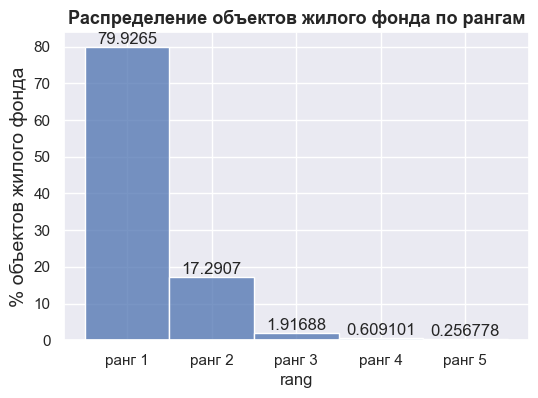

In [20]:
hist_percent(data=df2['rang'], title='Распределение объектов жилого фонда по рангам')

Модель ранговой классификации определила большее количество объектов жилого фонда, наиболее благоприятных для проживания семей с детьми, нежеди модель бинарной классификации. Это связано с тем, что в данную модель были добавлены веса для объектов исследования. Например, школам и детским садам присвоен вес 25%, а спортивным площадкам - 10%. Обеспеченность школами в районах Москвы гораздо выше, чем спортивными площадками, поэтому ранг 1 вырос. В бинарной классификации все исследуемые объекты по умолчанию имеют одинаковый вес.

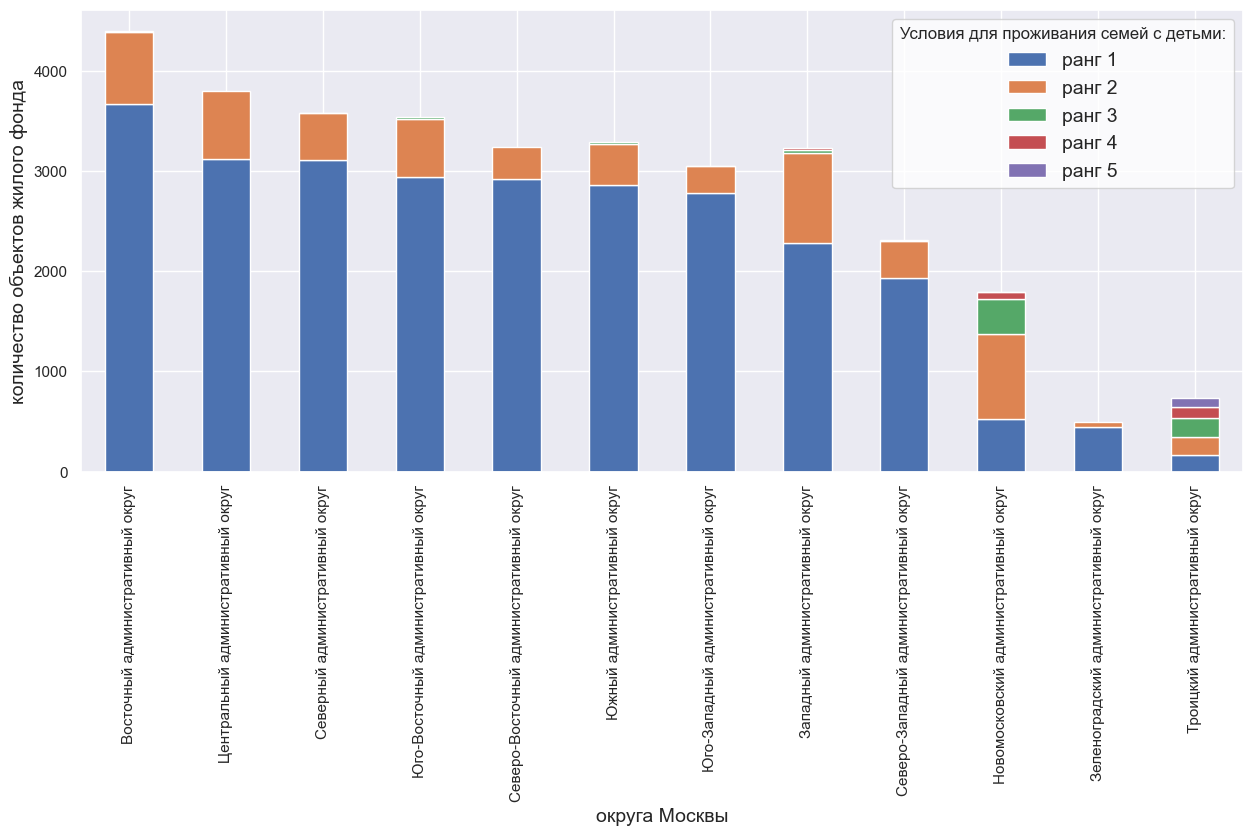

In [21]:
bar_class(data=df2.pivot_table(index='okrug_name', values='full_id', columns='rang', aggfunc='count').reset_index()\
    .sort_values('ранг 1', ascending=False), name="okrug_name", xlabel='округа Москвы',
           y=["ранг 1", "ранг 2", "ранг 3", "ранг 4", "ранг 5"])

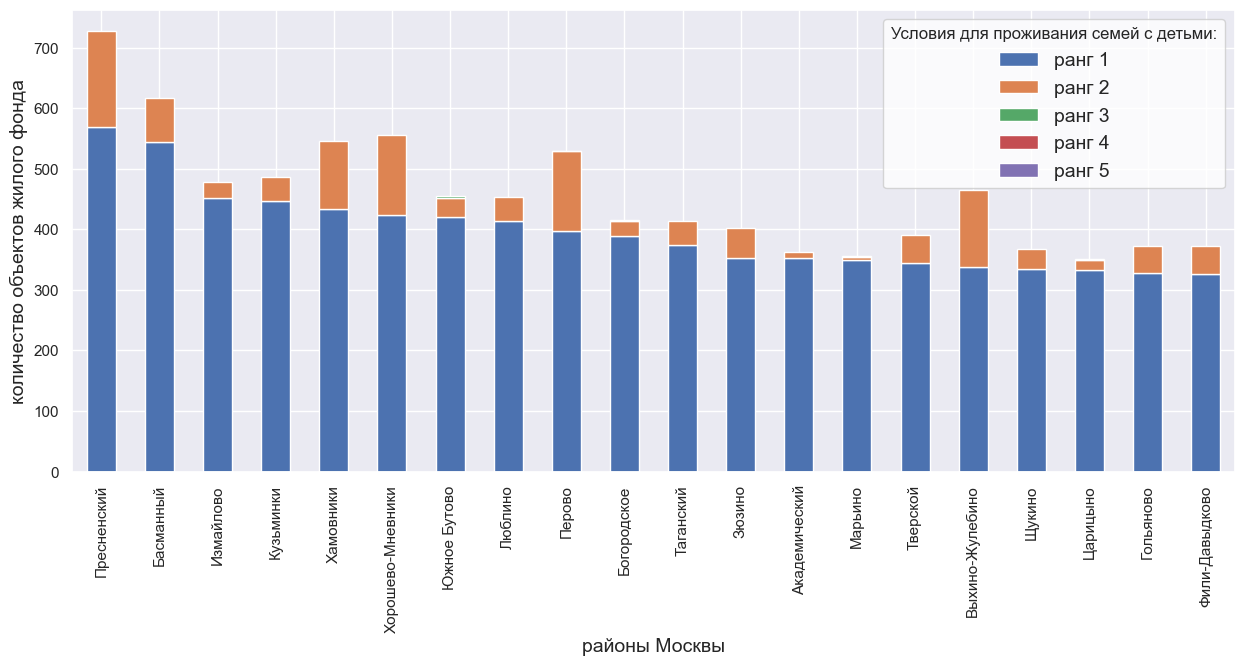

In [22]:
bar_class(data=df2.pivot_table(index='adm_name', values='full_id', columns='rang', aggfunc='count').reset_index()\
    .sort_values('ранг 1', ascending=False).head(20), name="adm_name", xlabel='районы Москвы',
          y=["ранг 1", "ранг 2", "ранг 3", "ранг 4", "ранг 5"])

Из графиков следует, что в ВАО и ЦАО наибольшее количество объектов жилого фонда, благоприятного для проживания семей с детьми, среди районов лидируют - Басманный и Пресненский. Лидеры данных групп не отличаются от бинарной классификации.

Далее составим таблицу топ-10 районов Москвы с наибольшим количеством объектов жилого фонда, благоприятного для проживания семей с детьми.

In [23]:
df2.loc[df2['rang'] == 'ранг 1', :]\
    .pivot_table(index=['adm_name', 'okrug_name'], values='sub_ter', columns='rang', aggfunc='count').reset_index()\
    .sort_values('ранг 1', ascending=False).head(10)

rang,adm_name,okrug_name,ранг 1
90,Пресненский,Центральный административный округ,570
6,Басманный,Центральный административный округ,544
37,Измайлово,Восточный административный округ,452
49,Кузьминки,Юго-Восточный административный округ,447
121,Хамовники,Центральный административный округ,434
123,Хорошево-Мневники,Северо-Западный административный округ,424
132,Южное Бутово,Юго-Западный административный округ,420
57,Люблино,Юго-Восточный административный округ,414
86,Перово,Восточный административный округ,397
12,Богородское,Восточный административный округ,389


Преимущество ранговой классификации над бинарной в том, что с ее помощью мы можем определить районы, где условия крайне неблагоприятные - ранг 5, для которых школы, например расположены в более, чем 2,5 км, а спортивные площадки - более 5 км.

Далее посмотрим, какие районы лидируют со знаком минус - где наибольшее количество жилого фонда имеет ранг 5.

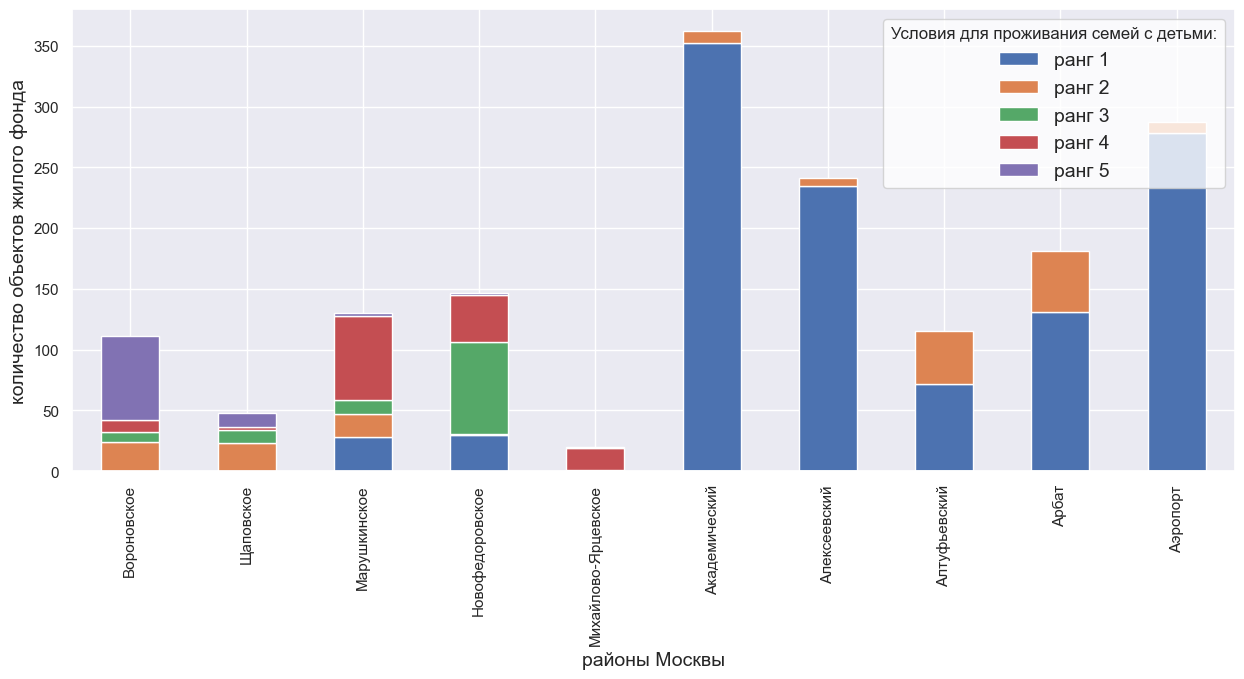

In [24]:
bar_class(data=df2.pivot_table(index='adm_name', values='full_id', columns='rang', aggfunc='count').reset_index()\
    .sort_values('ранг 5', ascending=False).head(10), name="adm_name", xlabel='районы Москвы',
          y=["ранг 1", "ранг 2", "ранг 3", "ранг 4", "ранг 5"])

## Вывод

В ходе данного исследования были рассмотрены две модели классификации, которые можно применить в пространственном анализе территорий, - бинарная и ранговая. Обе модели строились на анализе территориальной доступности объектов.

Модель бинарной классификации является менее сложной и дает ответ на вопрос - соответствует ли данная территория всем представленным требованиям к территориальной доступности объектов. 

Модель ранговой классификации является более сложной, но в то же время позволяет настраивать критерии для классов и определять веса для исследуемых объектов.

Обе представленные модели пространственного анализа могут быть использованы для оценки районов\локаций Москвы с точки зрения их привлекательности для семей с детьми, т.к. определяют территориальную доступность к основным социально-значимым объектам образования и досуга. Модели также могут быть масштабированы добавлением других социально-значимых объектов.